In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
DATA_PATH = "/Users/jubyaiduddin/Downloads/Senior_design/paper_reproduction/data/anemia.csv"
def load_and_clean(path=DATA_PATH):
    df = pd.read_csv(path, index_col=False)
    df.columns = df.columns.str.strip()
    # keep raw features + original Result
    df = df[["Gender", "Hemoglobin", "MCH", "MCHC", "MCV", "Result"]]
    # ensure Gender is numeric: 0 = male, 1 = female
    df["Gender"] = pd.to_numeric(df["Gender"], errors="raise")
    # recompute binary anemia flag per paper:
    # male (0): HGB < 13.6 → anemic; female (1): HGB < 12.0 → anemic
    df["AnemiaFlag"] = (
        ((df["Gender"] == 0) & (df["Hemoglobin"] < 13.6)) |
        ((df["Gender"] == 1) & (df["Hemoglobin"] < 12.0))
    ).astype(int)
    # derive 4-class Target per Table 3 & 4
    def to_target(r):
        if r["AnemiaFlag"] == 0:
            return 0  # no anemia
        if r["MCV"] < 80:
            return 1  # microcytic
        elif r["MCV"] <= 100:
            return 2  # normocytic
        else:
            return 3  # macrocytic
    df["Target"] = df.apply(to_target, axis=1)
    # drop helper columns
    #df = df.drop(columns=["Result", "AnemiaFlag"])
    # fill any remaining missing values
    if df.isnull().any().any():
        df = df.fillna(df.mean())
    return df

# load & inspect
df = load_and_clean()
print(f"Loaded {df.shape[0]} samples with columns: {df.columns.tolist()}")
df.head()

Loaded 1421 samples with columns: ['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV', 'Result', 'AnemiaFlag', 'Target']


,Gender,Hemoglobin,MCH,MCHC,MCV,Result,AnemiaFlag,Target
0,1,14.9,22.7,29.1,83.7,0,0,0
1,0,15.9,25.4,28.3,72.0,0,0,0
2,0,9.0,21.5,29.6,71.2,1,1,1
3,0,14.9,16.0,31.4,87.5,0,0,0
4,1,14.7,22.0,28.2,99.5,0,0,0


In [12]:
df.to_csv('processed_anemia_data.csv', index= False)

In [3]:
print("\nFeature summary (mean, min, max):")
print(df[["Hemoglobin","MCV","MCH","MCHC"]]
      .describe().loc[["mean","min","max"]])
print("\n4-class distribution (0=no,1=micro,2=normo,3=macro):")
print(df["Target"].value_counts().sort_index())


Feature summary (mean, min, max):
      Hemoglobin         MCV       MCH       MCHC
mean   13.412738   85.523786  22.90563  30.251232
min     6.600000   69.400000  16.00000  27.800000
max    16.900000  101.600000  30.00000  32.500000

4-class distribution (0=no,1=micro,2=normo,3=macro):
Target
0    857
1    175
2    341
3     48
Name: count, dtype: int64


In [4]:
X = df[["Gender","Hemoglobin","MCV","MCH","MCHC"]]
y = df["Target"]

In [5]:
#  5-fold CV to reproduce Table 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LDA": LinearDiscriminantAnalysis()
}

In [6]:
cv_results = {}
for name, clf in models.items():
    scores = []
    for train_idx, test_idx in kf.split(X):
        clf.fit(X.iloc[train_idx], y.iloc[train_idx])
        preds = clf.predict(X.iloc[test_idx])
        scores.append(accuracy_score(y.iloc[test_idx], preds))
    cv_results[name] = np.array(scores)
    print(f"{name}:")
    for i, s in enumerate(scores, 1):
        print(f"  Score {i}: {s:.8f}")
    print(f"  Mean: {cv_results[name].mean():.8f}")
    print(f"  Std:  {cv_results[name].std(ddof=1):.8f}\n")


RandomForest:
  Score 1: 1.00000000
  Score 2: 1.00000000
  Score 3: 1.00000000
  Score 4: 1.00000000
  Score 5: 1.00000000
  Mean: 1.00000000
  Std:  0.00000000

DecisionTree:
  Score 1: 1.00000000
  Score 2: 1.00000000
  Score 3: 1.00000000
  Score 4: 0.99647887
  Score 5: 1.00000000
  Mean: 0.99929577
  Std:  0.00157470

LDA:
  Score 1: 0.91929825
  Score 2: 0.92957746
  Score 3: 0.91901408
  Score 4: 0.93661972
  Score 5: 0.90492958
  Mean: 0.92188782
  Std:  0.01202815



In [ ]:
# 1) UPDATES  Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 2) Train RandomForest on the 80% training set
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 3) Predict on the 20% test set
y_pred = rf.predict(X_test)

# 4) Compute confusion matrix on the test set only
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3])

print("Confusion Matrix (80/20 hold-out):")
print(cm)

# 5) Detailed per-class metrics
print("\nClassification Report (on test set):")
print(classification_report(
    y_test, y_pred,
    labels=[0,1,2,3],
    target_names=["No", "Micro", "Normo", "Macro"]
))

In [ ]:
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X, y)
# y_pred = rf.predict(X)
# cm = confusion_matrix(y, y_pred, labels=[0,1,2,3])

# print("Confusion Matrix (full-data):")
# print(cm)
# print("\nClassification Report:")
# print(classification_report(
#     y, y_pred,
#     labels=[0,1,2,3],
#     target_names=["No","Micro","Normo","Macro"]
# ))

Confusion Matrix (full-data):
[[857   0   0   0]
 [  0 175   0   0]
 [  0   0 341   0]
 [  0   0   0  48]]

Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       857
       Micro       1.00      1.00      1.00       175
       Normo       1.00      1.00      1.00       341
       Macro       1.00      1.00      1.00        48

    accuracy                           1.00      1421
   macro avg       1.00      1.00      1.00      1421
weighted avg       1.00      1.00      1.00      1421



/var/folders/8m/qg941k596ljfzwjkrwdhd8kw0000gn/T/ipykernel_68718/295945096.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


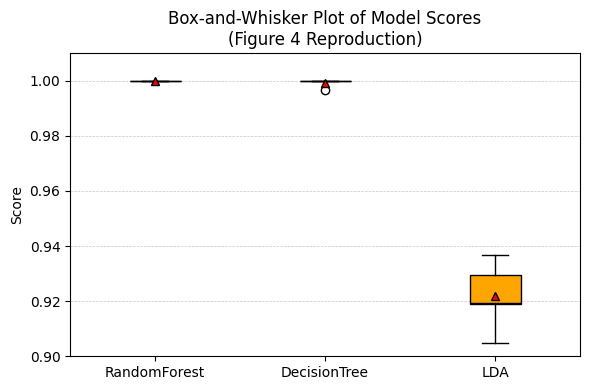

In [10]:
plt.figure(figsize=(6, 4))

# Prepare data in the order RandomForest, DecisionTree, LDA
data = [
    cv_results["RandomForest"],
    cv_results["DecisionTree"],
    cv_results["LDA"]
]

# Create boxplot
bp = plt.boxplot(
    data,
    labels=["RandomForest", "DecisionTree", "LDA"],
    patch_artist=True,      # to allow facecolor
    showmeans=True,         # show the mean marker
    meanprops=dict(
        marker='^',         # match paper’s little red triangle
        markerfacecolor='red',
        markeredgecolor='black'
    ),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    boxprops=dict(facecolor='orange', color='black')
)

plt.ylim(0.90, 1.01)
plt.ylabel("Score")
plt.title("Box-and-Whisker Plot of Model Scores\n(Figure 4 Reproduction)")
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

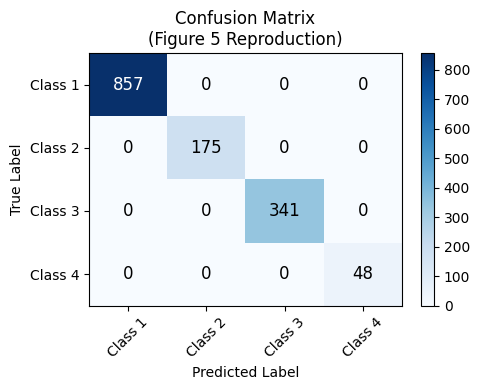

In [11]:
# %% Cell 10 — Annotated Confusion-Matrix Heatmap (Figure 5 Reproduction)

plt.figure(figsize=(5, 4))
cmap = plt.cm.Blues

# Display the heatmap
plt.imshow(cm, interpolation="nearest", cmap=cmap, aspect='auto')
plt.title("Confusion Matrix\n(Figure 5 Reproduction)")
plt.colorbar()

# Tick labels
class_labels = ["Class 1", "Class 2", "Class 3", "Class 4"]
plt.xticks(np.arange(4), class_labels, rotation=45)
plt.yticks(np.arange(4), class_labels)

# Annotate each cell with the count
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, f"{cm[i, j]}",
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=12
        )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


# Plotted Label | Underlying Code | Meaning
# Class 1       |               0 | No anemia
# Class 2       |               1 | Microcytic anemia (MCV < 80)
# Class 3       |               2 | Normocytic anemia (80 ≤ MCV ≤ 100)
# Class 4       |               3 | Macrocytic anemia (MCV > 100)


# Rows = True class

# Columns = Predicted class

# The cell at row i, column j shows how many samples of true class i were predicted as class j.

# E.g. the top-left cell “162” means 162 no-anemia cases (Class 1) were correctly predicted as no-anemia.

# Because all off-diagonal cells are zero, every sample was classified into its correct category.